# The Split-Bregman Algorithm: Sparsity Enforcing Inversions

@Author: Francesco Picetti - picettifrancesco@gmail.com

In this notebook we will show the Split-Bregman algorithm,
as described by [Goldstein and Osher, 2009](https://doi.org/10.1137/080725891).

In its generalized unconstrained formulation (the same we handle in this library), this algorithm
takes what we call `GeneralizedLasso` (see `occamypy.problem` module):

\begin{equation}
    \arg \min_\mathbf{x} \Vert  \mathbf{A} \mathbf{x} - \mathbf{d}\Vert_2^2 + \varepsilon \Vert \mathbf{R}_{L1} \mathbf{x}\Vert_1,
\end{equation}

being $\mathbf{x}$ our model, $\mathbf{d}$ the observed data, $\mathbf{A}$ a linear modeling operator,
$\mathbf{R}_{L1}$ the sparsity promoting regularizer and its weight $\varepsilon$.

#### Import modules

In [1]:
# Importing necessary modules
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : True,
    'figure.figsize' : (12, 3),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


##  Example 1:  1D Ricker Deconvolution

In this example we want to invert a 1D seismic trace for the Earth's reflectivity.
We suppose the wavelet to be known, yielding  to a deterministic deconvolution problem.

In [2]:
# load wavelet
wav = o.VectorNumpy(np.load("./data/ricker20.npy"))
nt = 51.
ot = 0.
dt = 0.002

# load reflectivity
x = o.VectorNumpy(np.load("./data/reflectivity1D.npy"))
time_axis = np.arange(x.size)*dt

# instantating operator
W = o.ConvND(x, wav)

# Generating true recorded trace
d = W * x

# Compute spectra
nfft = 4096
x_spectra = np.fft.fft(x.getNdArray(), nfft)
d_spectra = np.fft.fft(d.getNdArray(), nfft)
w_spectra = np.fft.fft(wav.getNdArray(), nfft)
freq = np.fft.fftfreq(nfft, dt)

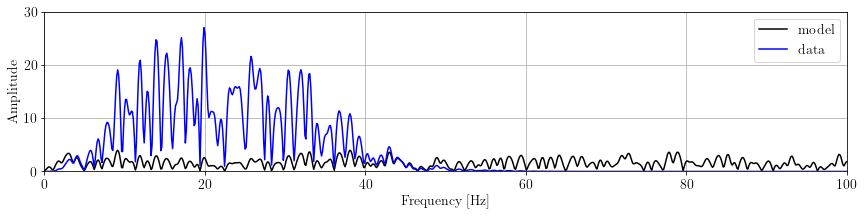

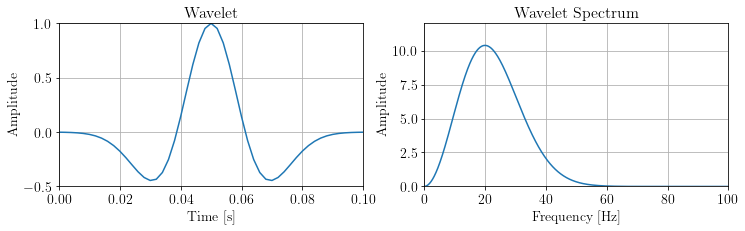

In [3]:
fig, ax = plt.subplots()
plt.plot(freq[:nfft//4], np.abs(x_spectra)[:nfft//4], 'k',  label='model')
plt.plot(freq[:nfft//4], np.abs(d_spectra)[:nfft//4], 'b',  label='data')
plt.legend(loc='upper right')
plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude")
plt.xlim(0,100), plt.ylim(0,30)
plt.tight_layout(pad=0.5)
plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(np.arange(wav.size)*dt, wav.plot())
ax[0].set_title('Wavelet')
ax[0].set_xlabel("Time [s]"), ax[0].set_ylabel("Amplitude")
ax[0].set_xlim(0,0.1), ax[0].set_ylim(-0.5,1)

ax[1].plot(freq[:nfft//4], np.abs(w_spectra)[:nfft//4])
ax[1].set_title('Wavelet Spectrum')
ax[1].set_xlabel("Frequency [Hz]"), ax[1].set_ylabel("Amplitude")
ax[1].set_xlim(0,100), ax[1].set_ylim(0,12)
plt.show()

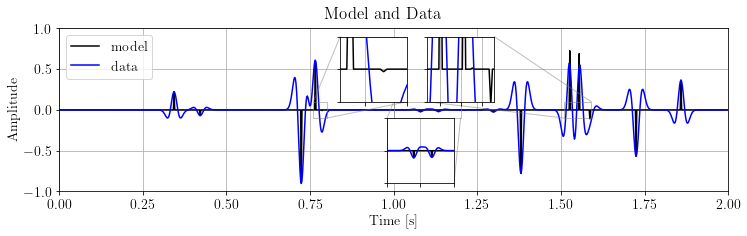

In [4]:
fig, ax = plt.subplots()
ax.plot(time_axis, x.plot(), 'k',  label='model')
ax.plot(time_axis, d.plot(), 'b',  label='data')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.plot(), 'k')
axins1.plot(time_axis, d.plot(), 'b')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.plot(), 'k')
axins2.plot(time_axis, d.plot(), 'b')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.plot(), 'k')
axins3.plot(time_axis, d.plot(), 'b')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.suptitle("Model and Data")
plt.show()

#### Solve with Conjugate Gradient

Conjugate gradient is a fast and powerful adjoint-state algorithm for solving problems in the form:

\begin{equation}
    \hat{\mathbf{x}} = \arg \min_\mathbf{x} \Vert \mathbf{W}\mathbf{x} - \mathbf{d}\Vert_2^2
\end{equation}

In [5]:
# instantiate a linear L2 problem
problemCG = o.LeastSquares(x.clone().zero(), d, W)

# define the solver with 10'000 iterations
CG = o.CG(o.BasicStopper(10000))
CG.setDefaults(save_obj=True)

# solve the problem
CG.run(problemCG, verbose=False)

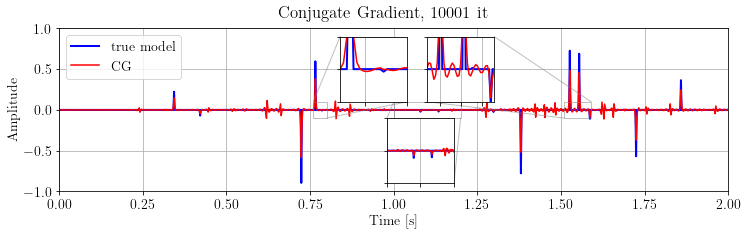

In [6]:
fig, ax = plt.subplots()
ax.plot(time_axis, x.plot(), 'b', lw=2, label='true model')
ax.plot(time_axis, problemCG.model.plot(), 'r',  label='CG')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.plot(), 'b', lw=2)
axins1.plot(time_axis, problemCG.model.plot(), 'r')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.plot(), 'b', lw=2)
axins2.plot(time_axis, problemCG.model.plot(), 'r')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.plot(), 'b', lw=2)
axins3.plot(time_axis, problemCG.model.plot(), 'r')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.suptitle('Conjugate Gradient, %d it' % len(CG.obj))
plt.show()

#### Impose sparsity in the solution: FISTA

Iterative Shrinkage-Thresholding Algorithms solve the so-called LASSO problem:
\begin{equation}
    \hat{\mathbf{x}} = \arg \min_\mathbf{x} \Vert \mathbf{W}\mathbf{x} - \mathbf{d}\Vert_2^2 + \lambda \Vert \mathbf{x}\Vert_1
\end{equation}

If we provide the operator's maximum eigenvalue $\eta$ we can build a fast version
of this algorithm by imposing the step $\alpha < 1/\eta^2$ as proposed in [Beck and Teboulle, 2009](https://doi.org/10.1137/080716542).

compute maximum eigenvalue

In [7]:
maxeig = W.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))

FISTA α=9.288505e-03


In [8]:
# define the LASSO problem
problemFISTA = o.Lasso(x.clone().zero(), d, W, lambda_value=1, op_norm=maxeig**2)

# instantiate the fast solver with 1000 iterations
FISTA = o.ISTA(o.BasicStopper(10000), fast=True)
FISTA.setDefaults(save_obj=True)

# solve the problem
FISTA.run(problemFISTA, verbose=False)

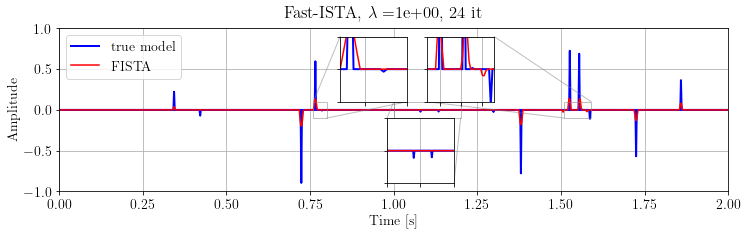

In [9]:
fig, ax = plt.subplots()
ax.plot(time_axis, x.plot(), 'b', lw=2, label='true model')
ax.plot(time_axis, problemFISTA.model.plot(), 'r',  label='FISTA')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.plot(), 'b', lw=2)
axins1.plot(time_axis, problemFISTA.model.plot(), 'r')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.plot(), 'b', lw=2)
axins2.plot(time_axis, problemFISTA.model.plot(), 'r')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.plot(), 'b', lw=2)
axins3.plot(time_axis, problemFISTA.model.plot(), 'r')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.suptitle(r'Fast-ISTA, $\lambda=$%.e, %d it' % (problemFISTA.lambda_value, len(FISTA.obj)))
plt.show()

Note that FISTA is able to recover the model's kinematics but not the true amplitude.
Indeed, this algorithm is very sensitive to $\lambda$ parameter.
Let's try another solver.

#### Split-Bregman for LASSO problem

In [10]:
# define the Linear Regularized Problem
problemSB = o.GeneralizedLasso(x.clone().zero(), d, W, reg=o.Identity(x), eps=.1)

# instantiate the Split-Bregman solver
SB = o.SplitBregman(o.BasicStopper(1000), niter_inner=3, niter_solver=5,
                    linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True)
# solve the problem
SB.run(problemSB, verbose=False, inner_verbose=False)

In [11]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

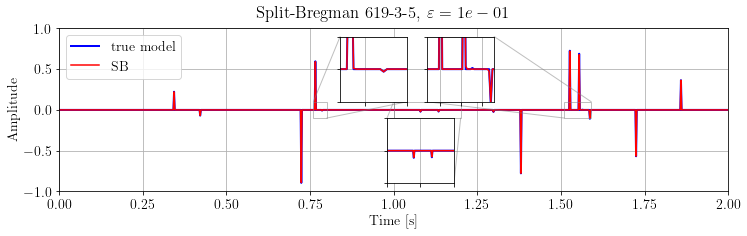

In [12]:
fig, ax = plt.subplots()
ax.plot(time_axis, x.plot(), 'b', lw=2, label='true model')
ax.plot(time_axis, problemSB.model.plot(), 'r',  label='SB')
ax.legend(loc='upper left')
ax.set_ylim(-1., 1.), ax.set_xlim(0,2)
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")

axins1 = ax.inset_axes([0.42, 0.55, 0.1, 0.4])
axins1.plot(time_axis, x.plot(), 'b', lw=2)
axins1.plot(time_axis, problemSB.model.plot(), 'r')
axins1.set_xlim(0.76, 0.8)
axins1.set_ylim(-.1, .1)
axins1.set_xticklabels('')
axins1.set_yticklabels('') 
ax.indicate_inset_zoom(axins1)

axins2 = ax.inset_axes([0.55, 0.55, 0.1, 0.4])
axins2.plot(time_axis, x.plot(), 'b', lw=2)
axins2.plot(time_axis, problemSB.model.plot(), 'r')
axins2.set_xlim(1.51, 1.59)
axins2.set_ylim(-.1, .1)
axins2.set_xticklabels('')
axins2.set_yticklabels('') 
ax.indicate_inset_zoom(axins2)

axins3 = ax.inset_axes([0.49, 0.05, 0.1, 0.4])
axins3.plot(time_axis, x.plot(), 'b', lw=2)
axins3.plot(time_axis, problemSB.model.plot(), 'r')
axins3.set_xlim(1.0, 1.2)
axins3.set_ylim(-.1, .1)
axins3.set_xticklabels('')
axins3.set_yticklabels('') 
ax.indicate_inset_zoom(axins3)

plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()

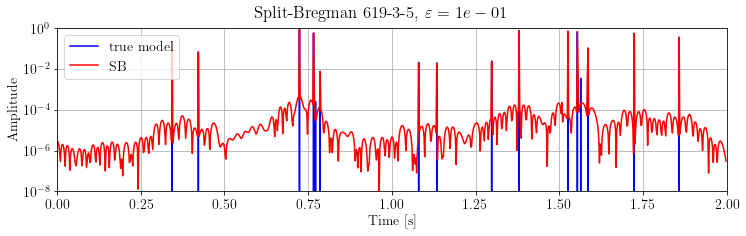

In [13]:
fig, ax = plt.subplots()
ax.semilogy(time_axis, np.abs(x.plot()), 'b', label="true model")
ax.semilogy(time_axis, np.abs(problemSB.model.plot()), 'r', label="SB")
ax.set_xlim(0,2), ax.set_ylim(1e-8, 1)
ax.legend(loc='upper left')
ax.set_xlabel("Time [s]"), ax.set_ylabel("Amplitude")

plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()

The results is much better than FISTA output: the dynamics is almost-perfectly recovered.


##  Example 2:  1D Velocity Deconvolution

Now we create a synthetic velocity profile and suppose to have recorded a smooth version of it.
The deconvolution problem aims at recovering the sharp model, and this is done by using a Total Variation regularizer.

In [14]:
# create the true model
nx = 201
x = o.VectorNumpy((nx,)).zero()
x[20:30] = 10.
x[50:75] = -5.
x[100:150] = 2.5
x[175:180] = 7.5

# instantiate the blurring operator
G = o.GaussianFilter(x, (2.,))

# simulate data
d = G * x

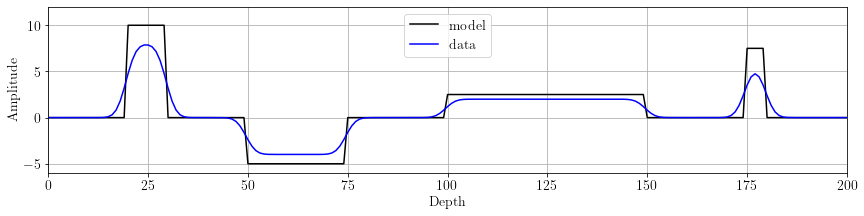

In [15]:
fig, ax = plt.subplots()
ax.plot(x.plot(), 'k',  label='model')
ax.plot(d.plot(), 'b',  label='data')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim(-6, 12)
plt.legend(loc="upper center")
ax.set_xlabel("Depth"), ax.set_ylabel("Amplitude")
plt.tight_layout(pad=.5)
plt.show()

As we can see, the model presents some flat regions. Let's have a look to its first derivative:

In [16]:
D = o.FirstDerivative(x, stencil='forward')
Dx = D * x

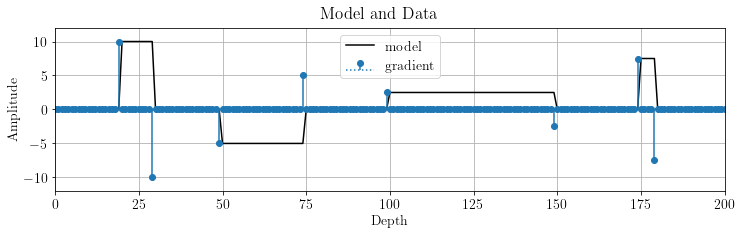

In [17]:
fig, ax = plt.subplots()
ax.plot(x.plot(), 'k',  label='model')
ax.stem(Dx.plot(), label='gradient', basefmt=':', use_line_collection=True)
ax.set_xlim(0,200), ax.set_ylim(-12, 12)
plt.legend(loc="upper center")
ax.set_xlabel("Depth"), ax.set_ylabel("Amplitude")
plt.suptitle("Model and Data")
plt.show()

The model derivative is sparse! We can set up a SplitBregman solver:

In [18]:
problem = o.GeneralizedLasso(x.clone().zero(), d, G, reg=D, eps=.1)

SB = o.SplitBregman(o.BasicStopper(200), niter_inner=3, niter_solver=10,
                           linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True, save_model=True)

SB.run(problem, verbose=False, inner_verbose=False)

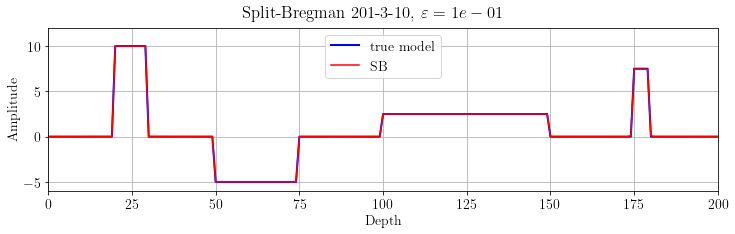

In [19]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

fig, ax = plt.subplots()
ax.plot(x.plot(), 'b', lw=2, label="true model")
ax.plot(problem.model.plot(), 'r', label="SB")
ax.set_ylim(-6, 12), ax.set_xlim(0, 200)
ax.legend(loc="upper center")
ax.set_xlabel("Depth"), ax.set_ylabel("Amplitude")

plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problem.eps))
plt.show()

Let's check the convergence:

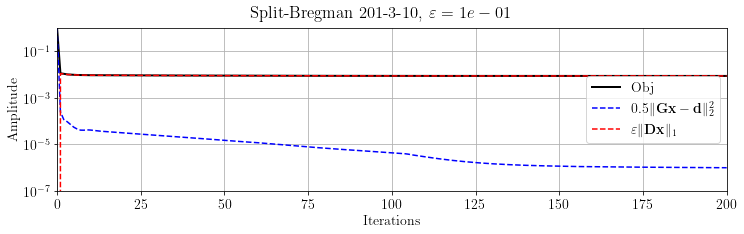

In [20]:
fig, ax = plt.subplots()
ax.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
ax.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
ax.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\varepsilon \Vert \mathbf{Dx}\Vert_1$")
ax.set_ylim(1e-7, 1), ax.set_xlim(0, SB.stopper.niter)
ax.set_xlabel("Iterations"), ax.set_ylabel("Amplitude")
ax.legend(loc="right")

plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problem.eps))
plt.show()

We can see that the L1 term reaches its final value after few iterations.
Let's see the inverted model after 2 iterations:

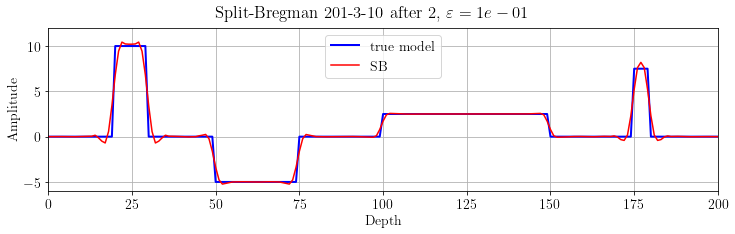

In [21]:
fig, ax = plt.subplots()
ax.plot(x.plot(), 'b', lw=2, label="true model")
ax.plot(SB.model[2].plot(), 'r', label="SB")
ax.set_ylim(-6, 12), ax.set_xlim(0, 200)
ax.legend(loc="upper center")
ax.set_xlabel("Depth"), ax.set_ylabel("Amplitude")

plt.suptitle(r'Split-Bregman %s after 2, $\varepsilon=%.e$' % (its, problem.eps))
plt.show()

Just for comparison, let's solve the problem with CG and FISTA.

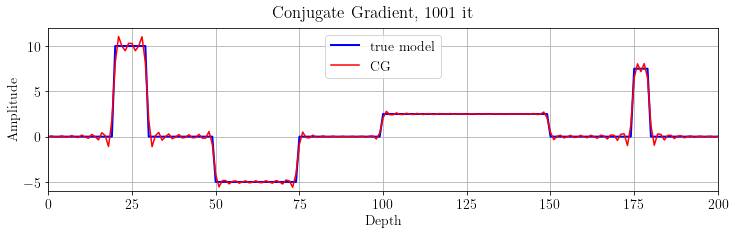

In [22]:
problemCG = o.LeastSquares(x.clone().zero(), d, G)
CG = o.CG(o.BasicStopper(1000))
CG.setDefaults(save_obj=True)
CG.run(problemCG, verbose=False)

fig, ax = plt.subplots()
ax.plot(x.plot(), 'b', lw=2, label="true model")
ax.plot(problemCG.model.plot(), 'r', label="CG")
ax.set_ylim(-6, 12), ax.set_xlim(0, 200)
ax.legend(loc="upper center")
ax.set_xlabel("Depth"), ax.set_ylabel("Amplitude")

plt.suptitle('Conjugate Gradient, %d it' % len(CG.obj))
plt.show()

FISTA α=1.570829e+00


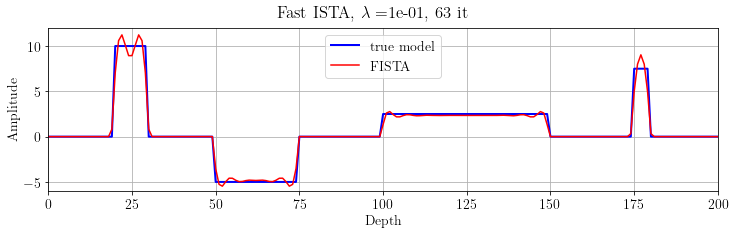

In [23]:
# compute maximum eigenvalue
maxeig = G.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))
problemFISTA = o.Lasso(x.clone().zero(), d, G, lambda_value=.1, op_norm=maxeig**2)
FISTA = o.ISTA(o.BasicStopper(1000), fast=True)
FISTA.setDefaults(save_obj=True)
FISTA.run(problemFISTA, verbose=False)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x.plot(), 'b', lw=2, label="true model")
ax.plot(problemFISTA.model.plot(), 'r', label="FISTA")

ax.set_ylim(-6, 12), ax.set_xlim(0, 200)
ax.legend(loc="upper center")
ax.set_xlabel("Depth"), ax.set_ylabel("Amplitude")

plt.suptitle(r'Fast ISTA, $\lambda=$%.e, %d it' % (problemFISTA.lambda_value, len(FISTA.obj)))
plt.show()

##  Example 3: 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse

In [24]:
# model
x = o.VectorNumpy(np.load('./data/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32)).scale(1 / 255.)

# operator
G = o.GaussianFilter(x, (3.,3.))

# data
d = G * x

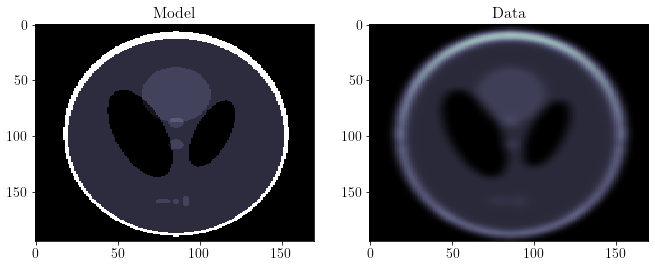

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))
ax[0].imshow(x.plot(), cmap='bone', clim=(0,1))
ax[0].grid(False)
ax[0].set_title('Model')
ax[1].imshow(d.plot(), cmap='bone', clim=(0,1))
ax[1].grid(False)
ax[1].set_title('Data')
plt.show()

Problem and solver:

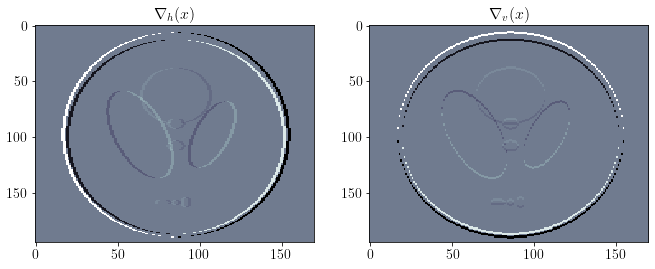

In [26]:
D = o.Gradient(x)
Dx = D * x

fig, ax = plt.subplots(1, 2, figsize=(11,4))
ax[0].imshow(Dx.vecs[1].plot(), cmap='bone')
ax[0].grid(False)
ax[0].set_title(r'$\nabla_h(x)$')
ax[1].imshow(Dx.vecs[0].plot(), cmap='bone')
ax[1].grid(False)
ax[1].set_title(r'$\nabla_v(x)$')
plt.show()

Just for comparison, let's solve the problem with CG.

In [27]:
problemCG = o.LeastSquares(x.clone().zero(), d, G)
CG = o.CG(o.BasicStopper(1000))
CG.setDefaults(save_obj=True)
CG.run(problemCG, verbose=False)

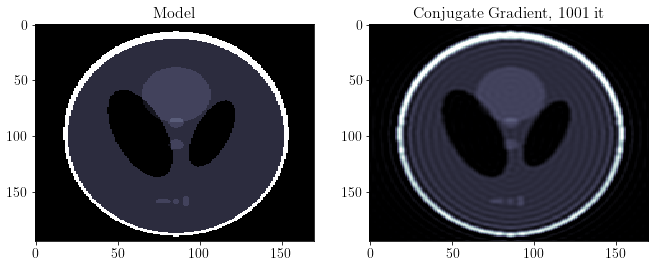

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))
ax[0].imshow(x.plot(), cmap='bone', clim=(0,1))
ax[0].grid(False)
ax[0].set_title('Model')
ax[1].imshow(problemCG.model.plot(), cmap='bone', clim=(0,1))
ax[1].grid(False)
ax[1].set_title('Conjugate Gradient, %d it' % len(CG.obj))
plt.show()

See the ringing effect there? Let's remove it by means of a regularizer!

In [29]:
problemSB = o.GeneralizedLasso(x.clone().zero(), d, G, reg=D, eps=1e-3)
SB = o.SplitBregman(o.BasicStopper(niter=200), niter_inner=3, niter_solver=10,
                           linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True)
SB.run(problemSB, verbose=False, inner_verbose=False)

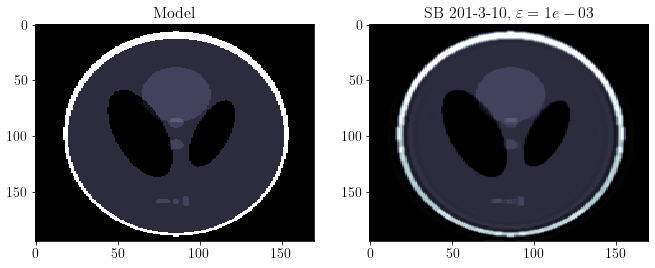

In [30]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

fig, ax = plt.subplots(1, 2, figsize=(11,4))
ax[0].imshow(x.plot(), cmap='bone', clim=(0,1))
ax[0].grid(False)
ax[0].set_title('Model')
ax[1].imshow(problemSB.model.plot(), cmap='bone', clim=(0,1))
ax[1].grid(False)
ax[1].set_title(r'SB %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()

Again, let's evaluate the objective function terms

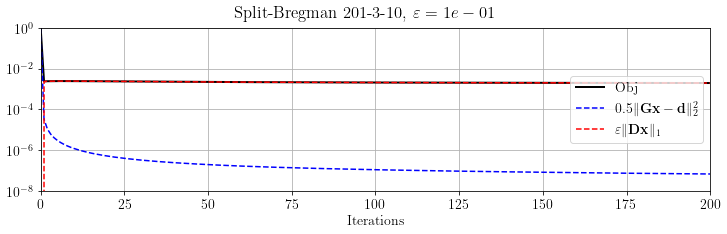

In [31]:
fig, ax = plt.subplots()
ax.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
ax.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
ax.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\varepsilon \Vert \mathbf{Dx}\Vert_1$")
ax.set_ylim(1e-8, 1), ax.set_xlim(0, SB.stopper.niter)
ax.set_xlabel("Iterations")
ax.legend(loc="right")

plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problem.eps))
plt.show()